In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from itertools import product

from tqdm import tqdm

plt.rcParams.update({'figure.figsize': (15, 7), 'figure.dpi': 120})

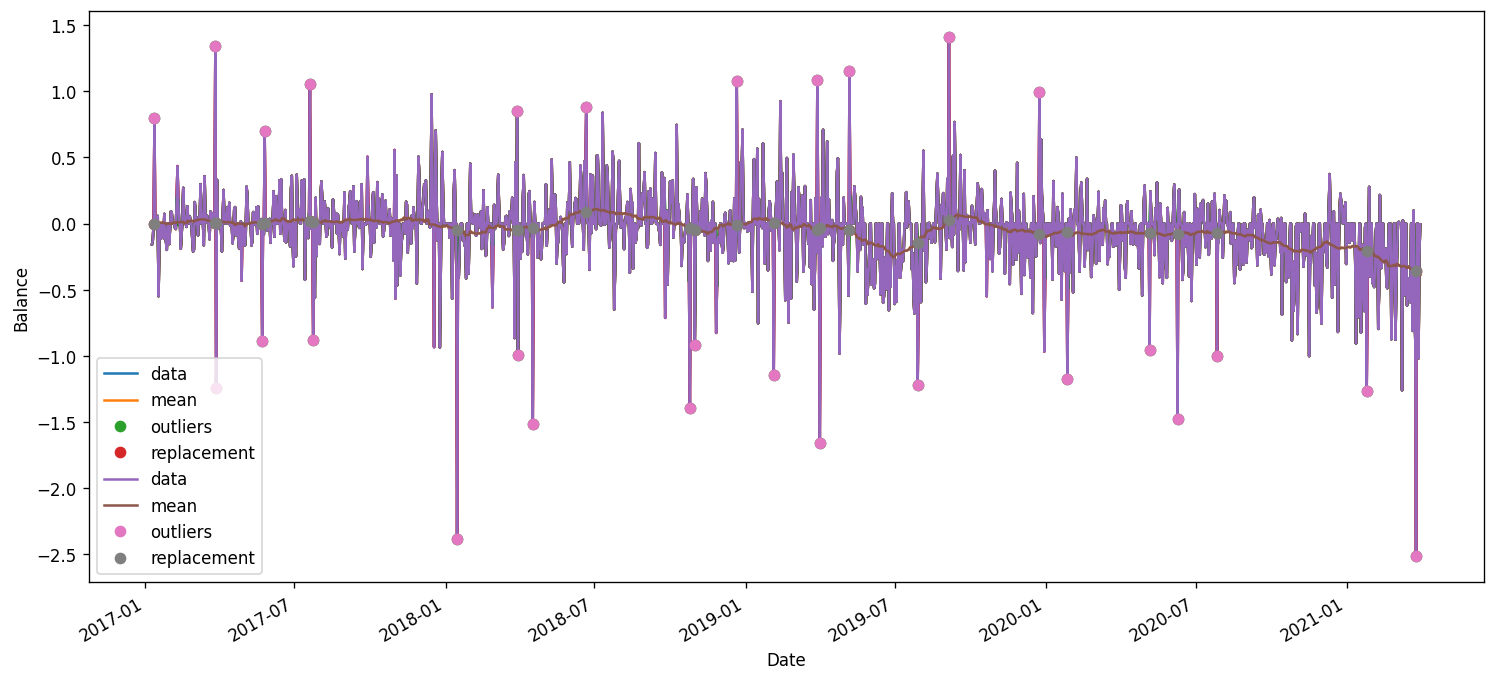

In [2]:
df = pd.read_excel("./Project 1_2024.xlsx", parse_dates=['Date'], index_col='Date', usecols=['Balance', 'Date'])

start_date = df.index[0]
threshold_date = np.datetime64('2019-07-30')
end_date = df.index[-1]#np.datetime64('2020-09-11')

mask_before = (df.index < threshold_date) & (df.index >= start_date)
mask_after = (df.index >= threshold_date) & (df.index <= end_date)

# избавление от выбросов, графики ес че уберешь

def zscore(s, window, thresh=3, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)   
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

Balance_balanced = zscore(df.Balance, window=50)

sns.lineplot(df.Balance, color='red')
sns.lineplot(Balance_balanced, color='green')

z, avg, std, m = zscore(df.Balance, window=70, return_all=True)

ax = plt.subplot()

df.Balance.plot(label='data')
avg.plot(label='mean')
df.loc[~m, 'Balance'].plot(label='outliers', marker='o', ls='')
avg[~m].plot(label='replacement', marker='o', ls='')
plt.legend()

df.Balance = Balance_balanced

USD_RUB_df = pd.read_csv(
    "./USD_RUB.csv",
    index_col='Дата', 
    parse_dates=['Дата'],
    usecols=['Дата', 'Цена'],
    )
    
USD_RUB_df.rename(columns={'Цена' : 'USD'}, inplace=True)

new_df = df.join(USD_RUB_df)
while not new_df.USD.notna().all():
    new_df.fillna(new_df.shift(1), inplace=True)
new_df.USD = new_df.USD.str.replace(',', '.').astype(float)


GDP = {2016: 1.28, 2017: 1.57, 2018: 1.66, 2019: 1.69, 2020: 1.49, 2021: 1.84} # in trillions

new_df['last_year_GDP'] = (new_df.index.year - 1)
new_df['last_year_GDP'] = new_df['last_year_GDP'].apply(lambda x: GDP[x])

GDP = pd.read_excel("./VVP_kvartal_s 1995-2023.xlsx", "2")[2:]
GDP = GDP.iloc[1]

offset = 4 * (2016-2011)
GDP = GDP[offset:]

new_df['quartal'] = new_df.index.month // 4 + 1
new_df['quartal'] = (new_df.index.year - 2016)*4 + new_df['quartal']

new_df['GDP_by_prev_quartal'] = new_df['quartal'].apply(lambda quartal: GDP[quartal - 2])

new_df.drop(columns='quartal', inplace=True)

keyRates = pd.read_csv('./KeyRate.csv', header=None, names=['dates', 'rates'],  sep=';', index_col='dates')
keyRates.index = pd.to_datetime(keyRates.index)
keyRates.sort_index(inplace=True)
new_df['key_rate'] = new_df.index.to_series().apply(lambda date: keyRates.rates[keyRates.index <= date][-1])

import holidays

all_holidays = pd.to_datetime(np.fromiter(holidays.RU(years=[2017, 2018, 2019, 2020, 2021]).keys(), 'datetime64[ns]'))
new_df['holiday'] = new_df.index.isin(all_holidays).astype(int)

bool_holiday = new_df.holiday.astype(bool)
new_df['week_before_holiday'] = bool_holiday.shift(-1).fillna(0)| \
    bool_holiday.shift(-2).fillna(0) | bool_holiday.shift(-3).fillna(0) | \
    bool_holiday.shift(-4).fillna(0) | bool_holiday.shift(-5).fillna(0) | \
    bool_holiday.shift(-6).fillna(0) | bool_holiday.shift(-7).fillna(0)
new_df.week_before_holiday = new_df.week_before_holiday.astype(int)

new_df['day_before_holiday'] = new_df.holiday.shift(-1).fillna(0).astype(int)
new_df['spring'] = new_df.index.month.isin([3,4,5]).astype(int)
new_df['summer'] = new_df.index.month.isin([6,7,8]).astype(int)
new_df['autumn'] = new_df.index.month.isin([9,10,11]).astype(int)
new_df['winter'] = new_df.index.month.isin([12,1,2]).astype(int)

new_df['weekdays'] = new_df.index.day_name()
new_df = new_df.join(new_df['weekdays'].str.get_dummies()).drop(columns='weekdays')
for weekday in new_df.index.day_name().unique(): new_df[weekday] = new_df[weekday].astype(int)

new_df['month'] = new_df.index.month_name()
new_df = new_df.join(new_df['month'].str.get_dummies()).drop(columns='month')

df = pd.read_excel("./Project 1_2024.xlsx", parse_dates=['Date'], index_col='Date', usecols=['Balance', 'Date'])

start_date = df.index[0]
threshold_date = np.datetime64('2019-07-30')
end_date = df.index[-1]#np.datetime64('2020-09-11')

mask_before = (df.index < threshold_date) & (df.index >= start_date)
mask_after = (df.index >= threshold_date) & (df.index <= end_date)

# избавление от выбросов, графики ес че уберешь

def zscore(s, window, thresh=3, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)   
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

Balance_balanced = zscore(df.Balance, window=50)

sns.lineplot(df.Balance, color='red')
sns.lineplot(Balance_balanced, color='green')

z, avg, std, m = zscore(df.Balance, window=70, return_all=True)

ax = plt.subplot()

df.Balance.plot(label='data')
avg.plot(label='mean')
df.loc[~m, 'Balance'].plot(label='outliers', marker='o', ls='')
avg[~m].plot(label='replacement', marker='o', ls='')
plt.legend()

df.Balance = Balance_balanced

USD_RUB_df = pd.read_csv(
    "./USD_RUB.csv",
    index_col='Дата', 
    parse_dates=['Дата'],
    usecols=['Дата', 'Цена'],
    )
    
USD_RUB_df.rename(columns={'Цена' : 'USD'}, inplace=True)

new_df = df.join(USD_RUB_df)
while not new_df.USD.notna().all():
    new_df.fillna(new_df.shift(1), inplace=True)
new_df.USD = new_df.USD.str.replace(',', '.').astype(float)


GDP = {2016: 1.28, 2017: 1.57, 2018: 1.66, 2019: 1.69, 2020: 1.49, 2021: 1.84} # in trillions

new_df['last_year_GDP'] = (new_df.index.year - 1)
new_df['last_year_GDP'] = new_df['last_year_GDP'].apply(lambda x: GDP[x])

GDP = pd.read_excel("./VVP_kvartal_s 1995-2023.xlsx", "2")[2:]
GDP = GDP.iloc[1]

offset = 4 * (2016-2011)
GDP = GDP[offset:]

new_df['quartal'] = new_df.index.month // 4 + 1
new_df['quartal'] = (new_df.index.year - 2016)*4 + new_df['quartal']

new_df['GDP_by_prev_quartal'] = new_df['quartal'].apply(lambda quartal: GDP[quartal - 2])

new_df.drop(columns='quartal', inplace=True)

keyRates = pd.read_csv('./KeyRate.csv', header=None, names=['dates', 'rates'],  sep=';', index_col='dates')
keyRates.index = pd.to_datetime(keyRates.index)
keyRates.sort_index(inplace=True)
new_df['key_rate'] = new_df.index.to_series().apply(lambda date: keyRates.rates[keyRates.index <= date][-1])

import holidays

all_holidays = pd.to_datetime(np.fromiter(holidays.RU(years=[2017, 2018, 2019, 2020, 2021]).keys(), 'datetime64[ns]'))
new_df['holiday'] = new_df.index.isin(all_holidays).astype(int)

bool_holiday = new_df.holiday.astype(bool)
new_df['week_before_holiday'] = bool_holiday.shift(-1).fillna(0)| \
    bool_holiday.shift(-2).fillna(0) | bool_holiday.shift(-3).fillna(0) | \
    bool_holiday.shift(-4).fillna(0) | bool_holiday.shift(-5).fillna(0) | \
    bool_holiday.shift(-6).fillna(0) | bool_holiday.shift(-7).fillna(0)
new_df.week_before_holiday = new_df.week_before_holiday.astype(int)

new_df['day_before_holiday'] = new_df.holiday.shift(-1).fillna(0).astype(int)
new_df['spring'] = new_df.index.month.isin([3,4,5]).astype(int)
new_df['summer'] = new_df.index.month.isin([6,7,8]).astype(int)
new_df['autumn'] = new_df.index.month.isin([9,10,11]).astype(int)
new_df['winter'] = new_df.index.month.isin([12,1,2]).astype(int)

new_df['weekdays'] = new_df.index.day_name()
new_df = new_df.join(new_df['weekdays'].str.get_dummies()).drop(columns='weekdays')
for weekday in new_df.index.day_name().unique(): new_df[weekday] = new_df[weekday].astype(int)

new_df['month'] = new_df.index.month_name()
new_df = new_df.join(new_df['month'].str.get_dummies()).drop(columns='month')


In [3]:
from xgboost import XGBRegressor

In [4]:
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

def mutualInfoSelection(X, y):
    selector = SelectPercentile(mutual_info_regression, percentile=25)
    selector.fit_transform(X, y)
    cols = selector.get_support(indices=True)
    selected_columns = X.iloc[:,cols].columns.tolist()
    return selected_columns

from sklearn.feature_selection import SequentialFeatureSelector as SFS

def sequentialFeatureSelection(model, X, y):
    sfs = SFS(
      estimator = model,
      n_features_to_select="auto",
      tol=0.01,
      direction='backward',
      scoring='neg_mean_absolute_error'
    )
    sfs = sfs.fit(X, y)
    return sfs.get_feature_names_out()

In [5]:
class FeatureSelector():
    def __init__(self, method, y, X_endog, X_exog = None, model=None):
        self.X_endog = X_endog
        self.X_exog = X_exog
        self.y = y
        self.mdltype = type(model).__name__
        if method in ['sfs', 'mi']:
            self.method = method
        else: raise KeyError
        if model is not None:
              self.model = model

    def select(self):
        sub_X_exog = []
        sub_X = []
        if self.X_exog is not None:
            X = pd.concat([self.X_endog, self.X_exog], axis = 1)
        if self.method == 'sfs':
            if 'ARIMA' in self.mdltype:
                sub_X_exog = sequentialFeatureSelection(self.model, self.X_exog, self.y)
            else:
                sub_X = sequentialFeatureSelection(self.model, X, self.y)
        elif self.method == 'mi':
            sub_X = mutualInfoSelection(X, self.y)
        if self.X_exog is not None: return sub_X
        else: return sub_X_exog

In [6]:
class AnomalyDetector(object):
    """
    Class which use CUSUM anomaly detection.

    A cumulative sum (CUSUM) chart is a type of control chart used to monitor small shifts in the process mean.

    Parameters
    ----------
    backward_window_size : integer, optional, default 30
        The window size of timeseries for estimate stats (like train)

    forward_window_size : integer, optional, default 14
        The window size of timeseries for compare with backward_window_size (like test)

    threshold : float, optional, default 5.0
        The maximum(minimum, with opposite sign) value of cumulative changes

    drift : float, optional, default 1.0
        The permissible deviation of timeseries from the mean

    Attributes
    ----------
    anomalies_ : timeseries of binary value (with initial timeseries index), where 1 - anomaly, 0 - non-anomaly
    """

    def __init__(self, backward_window_size=30, forward_window_size=14, threshold=5.0, drift=1.0):
        self.backward_window_size = backward_window_size
        self.forward_window_size = forward_window_size
        self.threshold = threshold
        self.drift = drift
        self.anomalies_ = None

    def one_pass(self, train_zone, prediction_zone, threshold=None, drift=None):
        """
        Detect anomaly in one pass

        Parameters
        ----------
        train_zone : pandas.Series or pandas.DataFrame
            Train sample to calculate statistics of timeseries

        prediction_zone : pandas.Series or pandas.DataFrame
            Test sample to find anomaly variables

        threshold : float, optional, default 5.0
            See parameter in ``threshold`` in :class:`AnomalyDetector`:func:`__init__`

        drift : float, optional, default 1.0
            See parameter in ``drift`` in :class:`AnomalyDetector`:func:`__init__``

        Returns
        -------
        is_fault : binary numpy array, shape = [len(prediction_zone)]
            1 - anomaly, 0 - nonanomaly
        """

        if not threshold:
            threshold = self.threshold
        if not drift:
            drift = self.drift

        current_std = np.nanstd(train_zone, ddof=1)
        current_mean = np.nanmean(train_zone)
        drift = drift * current_std
        threshold = threshold * current_std

        x = prediction_zone.astype('float64')
        gp, gn = np.zeros(x.size), np.zeros(x.size)

        for i in range(1, x.size):
            gp[i] = max(gp[i - 1] + x[i] - current_mean - drift, 0)
            gn[i] = min(gn[i - 1] + x[i] - current_mean + drift, 0)

        is_fault = np.logical_or(gp > threshold, gn < -threshold)
        return is_fault

    def detect(self, time_series, threshold=None, drift=None, excluded_points=None):
        """
        Detect anomaly in rolling window (=forward_window_size)

        Parameters
        ----------
        time_series : pandas.Series
            Target timeseries

        threshold : float, optional, default 5.0
            See parameter in ``threshold`` in :class:`AnomalyDetector`:func:`__init__`

        drift : float, optional, default 1.0
            See parameter in ``drift`` in :class:`AnomalyDetector`:func:`__init__``

        excluded_points : pandas.Series.index
            Acquainted anomaly events. They will be removed from timeseries before anomaly detection

        Returns
        -------
        self.anomalies_ : pandas.Series, shape = [len(time_series)]
            Labeled timeseries with anomaly, where 1 - anomaly, 0 - nonanomaly
        """
        if excluded_points is not None:
            time_series[time_series.index.isin(excluded_points)] = np.nan

        ts_values = time_series.values
        ts_index = time_series.index

        detection_series = np.zeros(len(ts_values)).astype('int32')

        for ini_index in range(len(ts_values) - (self.backward_window_size + self.forward_window_size)):
            sep_index = ini_index + self.backward_window_size
            end_index = sep_index + self.forward_window_size
            faults_indexes = self.one_pass(ts_values[ini_index:sep_index],
                                           ts_values[sep_index:end_index],
                                           threshold, drift)
            detection_series[sep_index:end_index][faults_indexes] = 1
        self.anomalies_ = pd.Series(detection_series, index=ts_index)

        return self.anomalies_

    def plot(self, time_series, ax=None, figsize=(14, 7),
             xlabel='Дата', ylabel='тысяч рублей', title='Plot Cusum Anomaly Detection',
             grid=True, marketsize=5):
        """
        Plot timeseries with anomaly points

        Parameters
        ----------
        time_series : pandas.Series
            Target timeseries

        ax : matplotlib object, optional, default None
            If ax is not None, use giving axis in current subplot

        figsize : tuple, optional, default (14, 7)
            If ax is None, figsize - size of plot

        xlabel : string, optional, default 'Дата'
            Label of x axis

        ylabel : string, optional, default 'тысяч рублей'
            Label of y axis

        title : string, optional, default 'Plot Cusum Anomaly Detection'
            Title of plot

        grid : boolean, optional, default True
            If True, use grid at plot

        marketsize : float, optional, default 5
            Size of anomaly points on timeseries plot

        Returns
        -------
        Plot timeseries with anomalies
        """
        anomalies = pd.Series(np.where(self.anomalies_ == 1, time_series, np.nan),
                              index=time_series.index)
        fig, ax = AnomalyDetector._conf_axs(ax, figsize, xlabel, ylabel, title, grid)
        ax.plot(time_series, label='actual')
        ax.plot(anomalies, 'o', color='r', markersize=marketsize, label='anomalies')
        ax.legend(loc='best')
        ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    def hist(self, meas='day', th=0.15, ax=None, figsize=(14, 7),
             xlabel='День месяца', ylabel='количество аномалий', title='Hist Cusum Anomaly Detection',
             grid=True):
        """
        Plot hist of anomaly points

        Parameters
        ----------
        meas : pd.datetime attribute, optional, default 'day'

        th : float, optional, default 0.15

        time_series : pandas.Series
            Target timeseries

        ax : matplotlib object, optional, default None
            If ax is not None, use giving axis in current subplot

        figsize : tuple, optional, default (14, 7)
            If ax is None, figsize - size of plot

        xlabel : string, optional, default 'День месяца'
            Label of x axis

        ylabel : string, optional, default 'количество аномалий'
            Label of y axis

        title : string, optional, default 'Plot Cusum Anomaly Detection'
            Title of plot

        grid : boolean, optional, default True
            If True, use grid at plot

        Returns
        -------
        Plot histogramm of anomalies per month
        """

        idx, anomaly_count, periodic_anomaly_idx = self.__count_anomaly(th, meas)
        simple_color = '#36b2e2'
        anomaly_gradient_colors = dict(zip(periodic_anomaly_idx,
                                           sns.color_palette("Reds", len(periodic_anomaly_idx)).as_hex()[::-1]))
        colors = [simple_color if x[1] / sum(anomaly_count) < th else anomaly_gradient_colors[x[0]]
                  for x in zip(idx, anomaly_count)]
        fig, ax = AnomalyDetector._conf_axs(ax, figsize, xlabel, ylabel, title, grid)
        ax.set_xlim(0, max(idx))
        ax.set_ylim(0, max(anomaly_count) + 1)
        ax.bar(idx, anomaly_count, color=colors)
        handles = [(x[0], anomaly_gradient_colors[x[0]])
                   for x in zip(idx, anomaly_count) if x[1] / sum(anomaly_count) >= th]
        handles = [mpatches.Patch(color=x[1], label=x[0]) for x in handles]
        ax.legend(handles=handles, bbox_to_anchor=(1.05, 1.05), fancybox=True, shadow=True)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    def __count_anomaly(self, th, meas):
        anomaly_idx = getattr(self.anomalies_[self.anomalies_ == 1].index, meas)
        count_anomalies_by_idx = sorted(Counter(anomaly_idx).items(), key=lambda x: x[1], reverse=True)
        idx = [x[0] for x in count_anomalies_by_idx]
        anomaly_count = [x[1] for x in count_anomalies_by_idx]
        periodic_anomaly_idx = [x[0] for x in count_anomalies_by_idx if x[1] / len(anomaly_idx) >= th]
        return idx, anomaly_count, periodic_anomaly_idx

    @staticmethod
    def _conf_axs(ax, figsize, xlabel, ylabel, title, grid):
        if ax is None:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
        else:
            fig = ax.get_figure()
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if grid:
            ax.grid(True)
        return fig, ax

In [7]:

from pactools.grid_search import GridSearchCVProgressBar

def find_params(model, X, y):
    param_grid = [
        {
            'n_estimators' : [1000, 3000],
            'learning_rate' : [.2, .3],
            'max_depth': [2, 3, 5],
            'min_child_weight': [3, 10],
            'grow_policy': ['depthwise'],
            'objective': ['reg:absoluteerror']
        }
    ]
    
    gridXGB = GridSearchCVProgressBar(model,
                       param_grid,
                       scoring='neg_mean_absolute_error',
                       cv=5).fit(X, y)
    return gridXGB.best_estimator_

In [8]:
new_df.index

DatetimeIndex(['2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18',
               ...
               '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
               '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29',
               '2021-03-30', '2021-03-31'],
              dtype='datetime64[ns]', name='Date', length=1543, freq=None)

In [9]:
new_df.index[-1]

Timestamp('2021-03-31 00:00:00')

In [10]:
from datetime import timedelta
new_df.index = pd.to_datetime(new_df.index)
# Установка дат начала, порога и окончания анализа
start_date = new_df.index[0]
threshold_date = np.datetime64('2021-01-30')
end_date = new_df.index[-1]

X = new_df.drop(columns=['Balance'])
y = new_df.Balance
exog = list(filter(lambda column: not column.startswith("shift"), X.columns))
endog = list(filter(lambda column: column.startswith("shift"), X.columns))

# Создание масок для фильтрации данных до и после пороговой даты
mask_before = (y.index < threshold_date) & (y.index >= start_date)
mask_after = (y.index >= threshold_date) & (y.index <= end_date)

# Параметры аномалий и моделирования
retrain_period = 25
anomaly_detection_window = 45

# Инициализация детектора аномалий
anomaly_detector = AnomalyDetector(backward_window_size=30, forward_window_size=7, threshold=5, drift=1.0)
Balance = new_df.Balance
preds = []
n_days = len(y[mask_after])
model = XGBRegressor()
columns = X.columns
# Перебор данных после пороговой даты и проверка на аномалии
today = pd.to_datetime(threshold_date)
for i in tqdm(range(1, n_days+1)):
    anomalies = anomaly_detector.detect(y.loc[:today])
    n_anomalies = anomalies.iloc[-7:].sum()
    # Обнаружение аномалий в текущем окне данных
    if n_anomalies >= 5:
        print(f"{today}\t!!!Anomaly!!!")
        plt.figure(figsize=(14, 4))
        plt.plot(y.loc[:today])
        tmp_anoms = anomalies.replace(0, np.nan).dropna()
        plt.scatter(tmp_anoms.index, y.loc[tmp_anoms.index],
                    color='red')
        plt.grid()
        plt.show()
    
    if i % retrain_period == 1 or n_anomalies >= 5:
        print(f"{today}\tRetraining model...")  # Здесь может быть логика переобучения, если нужно
        columns = FeatureSelector(method='mi', y=y.loc[:today], X_endog=X.loc[:today,endog], X_exog = X.loc[:today,exog], model=model).select()
        X_train = X[columns]
        X_train = X_train.loc[:today]
        y_train = y.loc[:today]
        model = find_params(model=model, X=X_train, y=y_train)
        model.fit(X_train, y_train)
    print(f"Predict {i}...")
    sub_X = X.loc[today, columns]
    preds.append(model.predict(pd.DataFrame([sub_X.tolist()], columns=sub_X.index))[0])

    if n_anomalies > 1:
        anomaly_detector.detect_and_visualize(new_df[mask_after].loc[:today])
    today += timedelta(days=1)

  0%|          | 0/61 [00:00<?, ?it/s]

2021-01-30 00:00:00	Retraining model...


  2%|▏         | 1/61 [22:51<22:51:13, 1371.22s/it]

Predict 1...


  3%|▎         | 2/61 [22:52<9:15:45, 565.18s/it]  

Predict 2...


  5%|▍         | 3/61 [22:53<4:57:14, 307.50s/it]

Predict 3...
Predict 4...


  8%|▊         | 5/61 [22:54<1:51:35, 119.56s/it]

Predict 5...


 10%|▉         | 6/61 [22:55<1:12:35, 79.19s/it] 

Predict 6...


 11%|█▏        | 7/61 [22:56<48:14, 53.60s/it]  

Predict 7...
Predict 8...


 15%|█▍        | 9/61 [22:58<22:10, 25.59s/it]

Predict 9...


 16%|█▋        | 10/61 [22:59<15:15, 17.94s/it]

Predict 10...


 18%|█▊        | 11/61 [23:00<10:34, 12.70s/it]

Predict 11...


 20%|█▉        | 12/61 [23:00<07:25,  9.09s/it]

Predict 12...


 21%|██▏       | 13/61 [23:01<05:17,  6.61s/it]

Predict 13...


 23%|██▎       | 14/61 [23:02<03:49,  4.88s/it]

Predict 14...
Predict 15...


 26%|██▌       | 16/61 [23:04<02:07,  2.83s/it]

Predict 16...


 28%|██▊       | 17/61 [23:05<01:38,  2.23s/it]

Predict 17...


 30%|██▉       | 18/61 [23:06<01:18,  1.82s/it]

Predict 18...
Predict 19...


 33%|███▎      | 20/61 [23:07<00:54,  1.32s/it]

Predict 20...


 34%|███▍      | 21/61 [23:08<00:47,  1.19s/it]

Predict 21...


 36%|███▌      | 22/61 [23:09<00:43,  1.12s/it]

Predict 22...
Predict 23...


 39%|███▉      | 24/61 [23:11<00:35,  1.04it/s]

Predict 24...


 41%|████      | 25/61 [23:12<00:33,  1.08it/s]

Predict 25...
2021-02-24 00:00:00	Retraining model...


 43%|████▎     | 26/61 [43:59<3:38:42, 374.94s/it]

Predict 26...
Predict 27...


 46%|████▌     | 28/61 [44:01<1:41:17, 184.17s/it]

Predict 28...


 48%|████▊     | 29/61 [44:02<1:08:54, 129.19s/it]

Predict 29...


 49%|████▉     | 30/61 [44:03<46:51, 90.68s/it]   

Predict 30...


 51%|█████     | 31/61 [44:04<31:52, 63.74s/it]

Predict 31...


 52%|█████▏    | 32/61 [44:04<21:41, 44.87s/it]

Predict 32...


 54%|█████▍    | 33/61 [44:05<14:45, 31.64s/it]

Predict 33...


 56%|█████▌    | 34/61 [44:06<10:04, 22.38s/it]

Predict 34...


 57%|█████▋    | 35/61 [44:07<06:54, 15.94s/it]

Predict 35...


 59%|█████▉    | 36/61 [44:08<04:46, 11.45s/it]

Predict 36...
Predict 37...


 62%|██████▏   | 38/61 [44:10<02:18,  6.04s/it]

Predict 38...


 64%|██████▍   | 39/61 [44:11<01:39,  4.51s/it]

Predict 39...


 66%|██████▌   | 40/61 [44:11<01:11,  3.42s/it]

Predict 40...


 67%|██████▋   | 41/61 [44:12<00:53,  2.66s/it]

Predict 41...


 69%|██████▉   | 42/61 [44:13<00:40,  2.13s/it]

Predict 42...
Predict 43...


 72%|███████▏  | 44/61 [44:15<00:25,  1.50s/it]

Predict 44...


 74%|███████▍  | 45/61 [44:16<00:20,  1.31s/it]

Predict 45...


 75%|███████▌  | 46/61 [44:17<00:17,  1.16s/it]

Predict 46...


 77%|███████▋  | 47/61 [44:18<00:15,  1.09s/it]

Predict 47...


 79%|███████▊  | 48/61 [44:18<00:13,  1.02s/it]

Predict 48...


 80%|████████  | 49/61 [44:19<00:11,  1.01it/s]

Predict 49...


 82%|████████▏ | 50/61 [44:20<00:10,  1.01it/s]

Predict 50...
2021-03-21 00:00:00	Retraining model...


 84%|████████▎ | 51/61 [1:02:31<54:39, 327.90s/it]

Predict 51...


 85%|████████▌ | 52/61 [1:02:32<34:28, 229.84s/it]

Predict 52...
Predict 53...


 89%|████████▊ | 54/61 [1:02:34<13:11, 113.05s/it]

Predict 54...
Predict 55...


 92%|█████████▏| 56/61 [1:02:35<04:39, 55.83s/it] 

Predict 56...


 93%|█████████▎| 57/61 [1:02:37<02:37, 39.40s/it]

Predict 57...


 95%|█████████▌| 58/61 [1:02:37<01:23, 27.83s/it]

Predict 58...


 97%|█████████▋| 59/61 [1:02:38<00:39, 19.74s/it]

Predict 59...


 98%|█████████▊| 60/61 [1:02:39<00:14, 14.07s/it]

Predict 60...
Predict 61...


100%|██████████| 61/61 [1:02:40<00:00, 61.65s/it]


In [11]:
preds

[-0.011826719,
 -0.05342888,
 -0.23290409,
 -0.05342888,
 -0.05342888,
 -0.05342888,
 -0.011826719,
 -0.011826719,
 -0.011826719,
 -0.19130193,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.15706758,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.19130193,
 0.0,
 -0.038484693,
 -0.050602004,
 -0.050602004,
 -0.02680567,
 -0.021431044,
 -0.21613987,
 -0.038484693,
 -0.038484693,
 -0.050602004,
 -0.038484693,
 -0.014688353,
 -0.009313729,
 -0.21613987,
 -0.038484693,
 -0.038484693,
 -0.038484693,
 -0.038484693,
 -0.014688353,
 -0.009313729,
 -0.18305585,
 -0.038484693,
 -0.038484693,
 -0.038484693,
 -0.038484693,
 -0.014688353,
 -1e-45,
 -0.07168433,
 -0.07168433,
 -0.07168433,
 -0.07168433,
 -0.07168433,
 -0.045787923,
 -0.029249059,
 -0.07168433,
 -0.07168433,
 -0.07168433]

In [12]:
calc = pd.DataFrame(columns = ['Balance', 'prediction', 'business_metric'])
calc['Balance'] = new_df.loc[pd.to_datetime(threshold_date):].Balance
calc['prediction'] = np.array(preds)
calc['diff'] = calc['Balance'] - calc['prediction']
keyRates = pd.read_csv('./KeyRate.csv', header=None, names=['dates', 'rates'],  sep=';', index_col='dates')
keyRates.index = pd.to_datetime(keyRates.index)
keyRates.sort_index(inplace=True)
calc['key_rate'] = calc.index.to_series().apply(lambda date: keyRates.rates[keyRates.index <= date][-1])
# здесь уже со сдвигом
calc['business_metric'][calc['diff'] > 0] = (calc['diff']*(calc['key_rate']-0.9)/100)[calc['diff'] > 0]
calc['business_metric'][calc['diff'] < 0] = (calc['diff']*(calc['key_rate']+1)/100)[calc['diff'] < 0]
calc['business_metric'][calc['diff'] == 0] = 0

/tmp/ipykernel_3676/3604286322.py:6: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  keyRates.index = pd.to_datetime(keyRates.index)
/tmp/ipykernel_3676/3604286322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  calc['key_rate'] = calc.index.to_series().apply(lambda date: keyRates.rates[keyRates.index <= date][-1])
/tmp/ipykernel_3676/3604286322.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermedia

In [13]:
calc

,Balance,prediction,business_metric,diff,key_rate
Date,,,,,
2021-01-30,0.000000,-0.011827,0.000396,0.011827,4.25
2021-01-31,0.000000,-0.053429,0.00179,0.053429,4.25
2021-02-01,-0.450338,-0.232904,-0.011415,-0.217434,4.25
2021-02-02,-0.392158,-0.053429,-0.017783,-0.338729,4.25
2021-02-03,-0.479495,-0.053429,-0.022368,-0.426066,4.25
...,...,...,...,...,...
2021-03-27,0.000000,-0.045788,0.001648,0.045788,4.50
2021-03-28,0.000000,-0.029249,0.001053,0.029249,4.50
2021-03-29,-1.017679,-0.071684,-0.05203,-0.945995,4.50


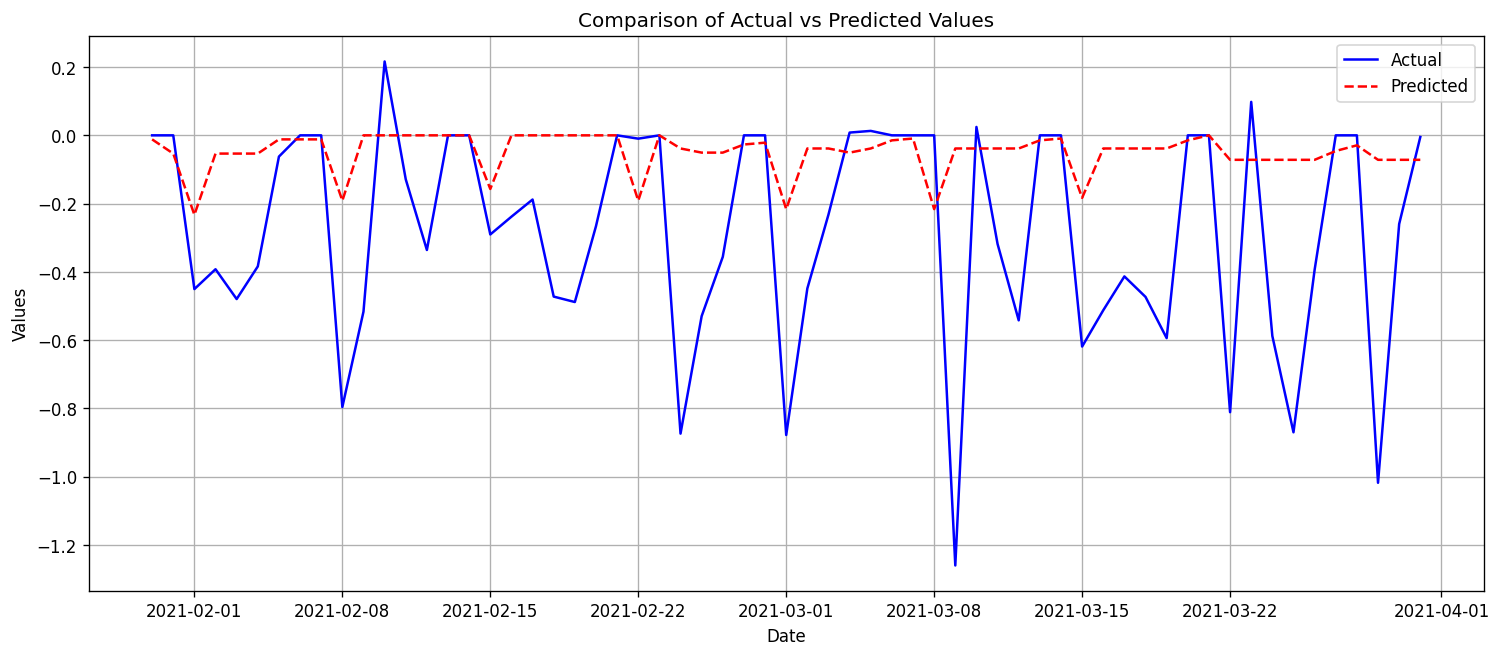

In [14]:
plt.figure(figsize=(15, 6))
plt.plot(calc.Balance, label='Actual', color='blue')
plt.plot(calc.prediction, label='Predicted', color='red', linestyle='--')
plt.title('Comparison of Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(calc.Balance, calc.prediction)
mae = mean_absolute_error(calc.Balance, calc.prediction)
r2 = r2_score(calc.Balance, calc.prediction)

display(f"Mean Squared Error (MSE): {mse}")
display(f"Mean Absolute Error (MAE): {mae}")
display(f"R^2 Score: {r2}")

'Mean Squared Error (MSE): 0.14851653512920845'

'Mean Absolute Error (MAE): 0.2738728982468783'

'R^2 Score: -0.43565665659349984'

In [16]:
def calculate_financial_impact(y_true, y_pred, key_rate):
    overnight_deposit_rate = key_rate - 0.009
    overnight_loan_rate = key_rate + 0.01

    errors = y_pred - y_true
    profit_loss = np.where(errors > 0,
                           errors * (overnight_deposit_rate - key_rate + 0.005),
                           errors * (overnight_loan_rate - key_rate))
    return profit_loss

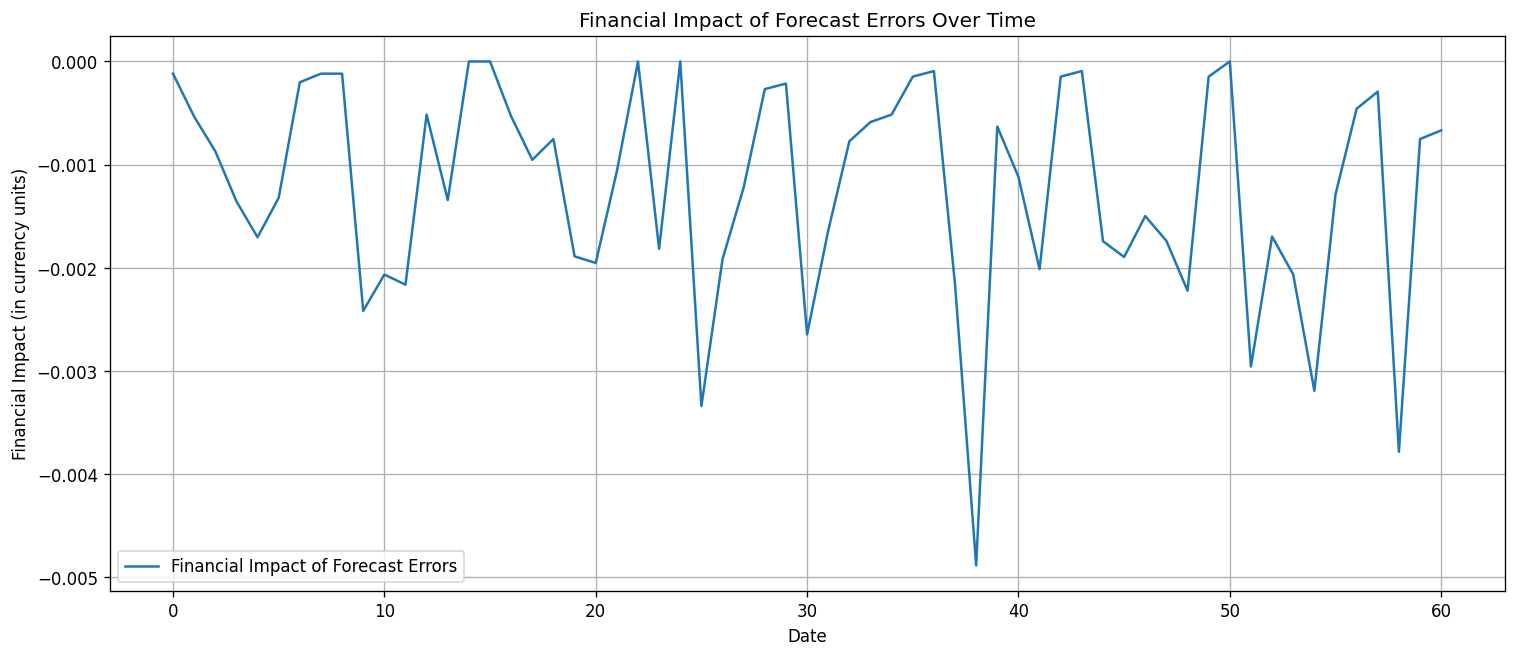

In [17]:
financial_impact = calculate_financial_impact(calc.Balance, calc.prediction, calc.key_rate)

plt.figure(figsize=(15, 6))
plt.plot(financial_impact, label='Financial Impact of Forecast Errors')
plt.title('Financial Impact of Forecast Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Financial Impact (in currency units)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
financial_impact.sum()

-0.0746175674624267